In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.stats import multivariate_normal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data from files

In [2]:
zeros_train = loadmat("Data\\training_data_0.mat")
zeros_test = loadmat("Data\\testing_data_0.mat")
ones_train = loadmat("Data\\training_data_1.mat")
ones_test = loadmat("Data\\testing_data_1.mat")

In [3]:
X_zeros_train = zeros_train['nim0'].T
X_ones_train = ones_train['nim1'].T
print(X_zeros_train.shape, X_ones_train.shape)

(5923, 28, 28) (6742, 28, 28)


In [4]:
X_zeros_test = zeros_test['nim0'].T
X_ones_test = ones_test['nim1'].T
print(X_zeros_test.shape, X_ones_test.shape)

(980, 28, 28) (1135, 28, 28)


## Dataset building

In [5]:
X_zeros_train = np.reshape(X_zeros_train, (-1, X_zeros_train.shape[1] * X_zeros_train.shape[2]))
X_ones_train = np.reshape(X_ones_train, (-1, X_ones_train.shape[1] * X_ones_train.shape[2]))
print(X_zeros_train.shape, X_ones_train.shape)

(5923, 784) (6742, 784)


In [6]:
X_zeros_test = np.reshape(X_zeros_test, (-1, X_zeros_test.shape[1] * X_zeros_test.shape[2]))
X_ones_test = np.reshape(X_ones_test, (-1, X_ones_test.shape[1] * X_ones_test.shape[2]))
print(X_zeros_test.shape, X_ones_test.shape)

(980, 784) (1135, 784)


In [7]:
X_train = np.concatenate((X_zeros_train, X_ones_train), axis=0)
X_test = np.concatenate((X_zeros_test, X_ones_test), axis=0)
print(X_train.shape, X_test.shape)

(12665, 784) (2115, 784)


In [8]:
y_train = np.concatenate((np.zeros(X_zeros_train.shape[0], dtype='int'), np.ones(X_ones_train.shape[0], dtype='int')), axis=0)
y_test = np.concatenate((np.zeros(X_zeros_test.shape[0], dtype='int'), np.ones(X_ones_test.shape[0], dtype='int')), axis=0)
print(y_train.shape, y_test.shape)

(12665,) (2115,)


## TASK 1: Feature Normalization (Data Conditioning)

In [9]:
def normalize(dataset):
    mean_vector = np.mean(dataset, axis=0)
    print("Shape of mean vector: {}".format(mean_vector.shape))
    std_vector = np.std(dataset, axis=0)
    print("Shape of std vector: {}".format(std_vector.shape))
    scaled_dataset = (dataset - mean_vector)/std_vector
    print("Shape of normalized data: {}".format(scaled_dataset.shape))
    
    return scaled_dataset

In [10]:
X_train_normalized = normalize(X_train)

Shape of mean vector: (784,)
Shape of std vector: (784,)
Shape of normalized data: (12665, 784)


In [11]:
X_test_normalized = normalize(X_test)

Shape of mean vector: (784,)
Shape of std vector: (784,)
Shape of normalized data: (2115, 784)


## TASK 2: PCA using the training samples

### 2(A): Compute the Covariance Matrix

In [12]:
covariance_matrix = np.cov(X_train_normalized.T)
print(covariance_matrix.shape)

(784, 784)


### 2(B): Eigen Analysis

In [13]:
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
print(eigen_values.shape, eigen_vectors.shape)

(784,) (784, 784)


In [14]:
eigen_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:, i]) for i in range(eigen_values.shape[0])]
eigen_pairs.sort(key=lambda x: x[0], reverse=True)

### 2(C) Identifying the Principal Components

In [15]:
explained_variance_threshold = 0.95

total_variance = sum(eigen_values)
explained_variances = [(i/total_variance) for i in sorted(eigen_values, reverse=True)]
cumulative_variances = np.cumsum(explained_variances)

num_principal_components = 0

for i, exp_var in enumerate(cumulative_variances):
    if exp_var > explained_variance_threshold:
        num_principal_components = i + 1
        break

print("# of Key principal components explaining {}% of data: {}".format(explained_variance_threshold*100, num_principal_components))

# of Key principal components explaining 95.0%% of data: 425


In [46]:
cumulative_variances[:2]

array([0.12686329, 0.17763248])

Text(0.5, 0, '# of PCs')

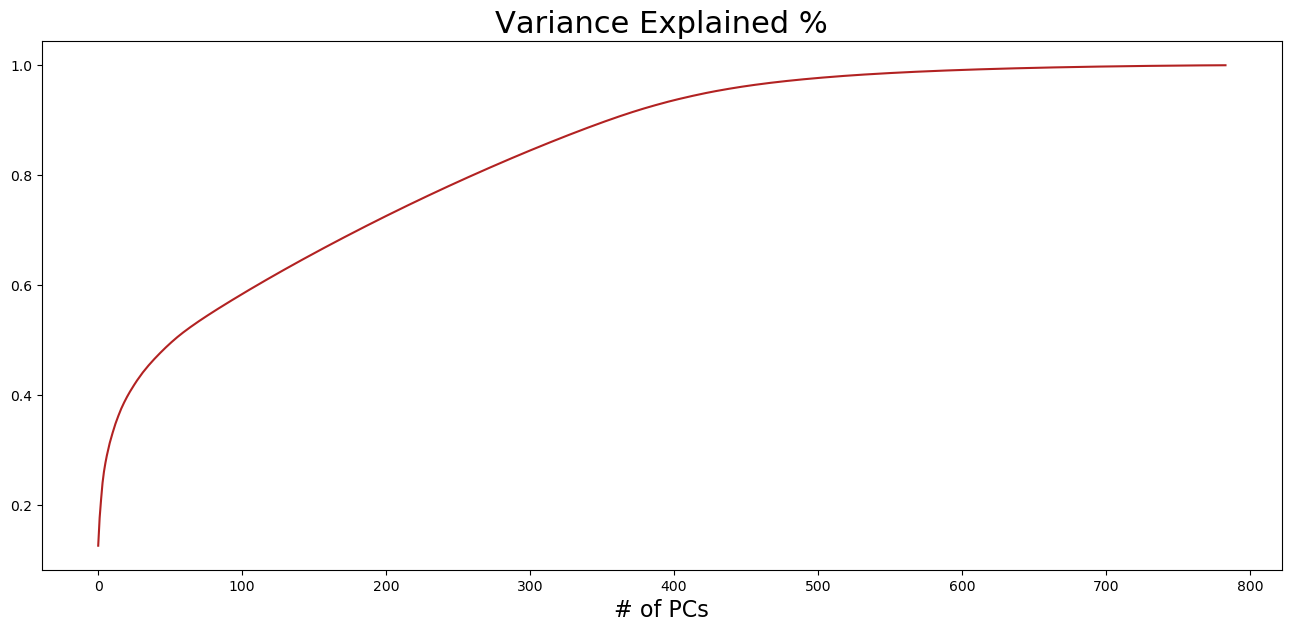

In [16]:
fig, axes = plt.subplots(1,1,figsize=(16,7), dpi=100)
plt.plot(cumulative_variances, color='firebrick')
plt.title('Variance Explained %', fontsize=22)
plt.xlabel('# of PCs', fontsize=16)

## TASK 3: Dimension Reduction using PCA

### 3(A): Consider 2D Projections of the samples on the first and second PCs

In [17]:
projection_matrix = np.hstack((eigen_pairs[0][1].reshape(-1, 1), eigen_pairs[1][1].reshape(-1, 1)))
projection_matrix.shape

(784, 2)

In [18]:
projected_data = X_train_normalized.dot(projection_matrix)
projected_data.shape

(12665, 2)

In [19]:
projected_test_data = X_test_normalized.dot(projection_matrix)
projected_test_data.shape

(2115, 2)

In [20]:
train_df = pd.DataFrame(projected_data)
train_df['Y'] = y_train

train_df.head()

,0,1,Y
0,-8.287507,6.037945,0
1,-9.144129,6.155182,0
2,-3.583865,11.406113,0
3,-6.751379,11.715123,0
4,-16.196927,2.401752,0


In [21]:
test_df = pd.DataFrame(projected_test_data)
test_df['Y'] = y_test

test_df.head()

,0,1,Y
0,-9.679202,5.509572,0
1,-10.007390,-5.126644,0
2,-9.005716,-1.883494,0
3,-18.967618,2.337952,0
4,-8.886077,2.051355,0


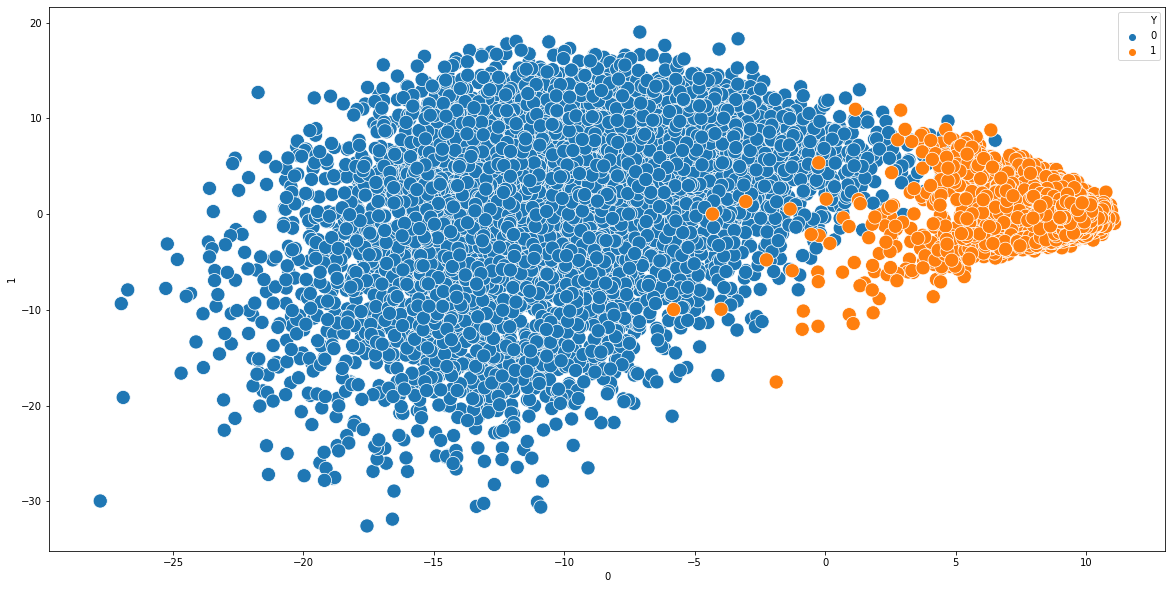

In [22]:
plt.figure(figsize=(20, 10))
sns.scatterplot(train_df[0], train_df[1], hue=train_df['Y'], s=200)

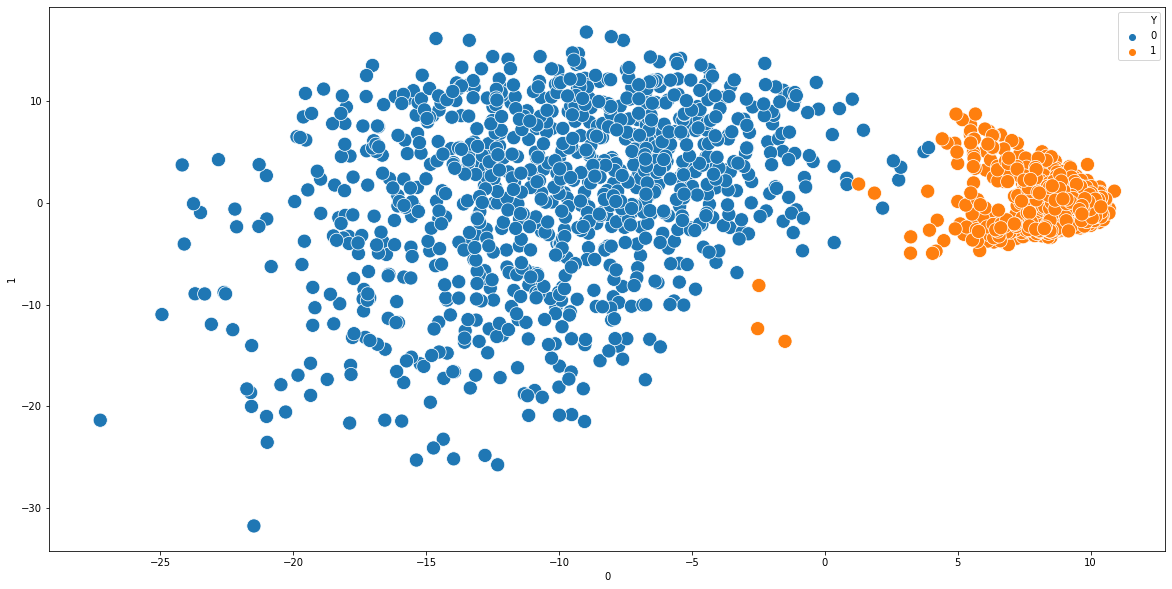

In [23]:
plt.figure(figsize=(20, 10))
sns.scatterplot(test_df[0], test_df[1], hue=test_df['Y'], s=200)

### 3(B) Plot/Visualize the training and testing samples in the 2D space

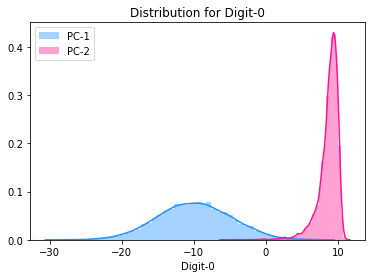

In [24]:
x0_0 = train_df.loc[train_df.Y == 0, 0]
x0_1 = train_df.loc[train_df.Y == 1, 0]

sns.distplot(x0_0, color='dodgerblue', label='PC-1')
sns.distplot(x0_1, color='deeppink', label='PC-2')
plt.gca().set(title='Distribution for Digit-0', xlabel='Digit-0')
plt.legend()

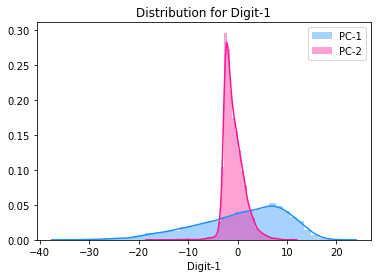

In [25]:
x1_0 = train_df.loc[train_df.Y == 0, 1]
x1_1 = train_df.loc[train_df.Y == 1, 1]

sns.distplot(x1_0, color='dodgerblue', label='PC-1')
sns.distplot(x1_1, color='deeppink', label='PC-2')
plt.gca().set(title='Distribution for Digit-1', xlabel='Digit-1')
plt.legend()

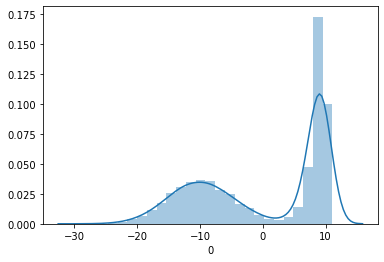

In [26]:
sns.distplot(train_df[0])

Y
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 0, dtype: object

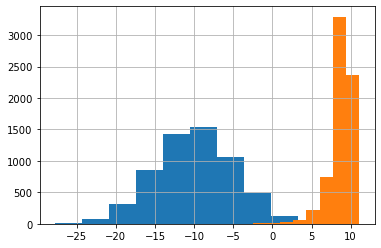

In [27]:
train_df.groupby('Y')[0].hist()

Y
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 1, dtype: object

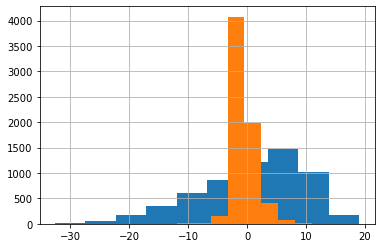

In [28]:
train_df.groupby('Y')[1].hist()

Each class looks like a normal distribution

## TASK 4: Density Estimation

### 4(A) Density Estimation for Class 0

In [27]:
mu_zero = np.mean(train_df[[0, 1]][train_df['Y'] == 0])
print("Mean Vector for Class 0: ")
print(mu_zero)

Mean Vector for Class 0: 
0   -9.923846
1    0.851457
dtype: float64


In [28]:
cov_mat_zero = np.cov(train_df[[0, 1]][train_df['Y'] == 0].T)
print("Covariance Matrix for Class 0: ")
print(cov_mat_zero)

Covariance Matrix for Class 0: 
[[25.32460567 15.90014464]
 [15.90014464 79.11311962]]


In [29]:
zero_distribution = multivariate_normal(mu_zero, cov_mat_zero)

### 4(B) Density Estimation for Class 1

In [30]:
mu_one = np.mean(train_df[[0, 1]][train_df['Y'] == 1])
print("Mean Vector for Class 1: ")
print(mu_one)

Mean Vector for Class 1: 
0    8.718324
1   -0.748024
dtype: float64


In [31]:
cov_mat_one = np.cov(train_df[[0, 1]][train_df['Y'] == 1].T)
print("Covariance Matrix for Class 1: ")
print(cov_mat_one)

Covariance Matrix for Class 1: 
[[ 2.06676736 -0.02148539]
 [-0.02148539  4.0841354 ]]


In [32]:
one_distribution = multivariate_normal(mu_one, cov_mat_one)

## TASK 5: Bayesion Decision Theory for optimal classification

Since the priors for both classes are equal, the decision relies solely on the likelihoods of data on each class

In [33]:
p_x_zero = lambda x: zero_distribution.pdf(x)
p_x_one = lambda x: one_distribution.pdf(x)

### 5(A) Minimum Error Rate Classification on the dataset

In [34]:
def classify(datapoint, p_zero=0.5, p_one=0.5):
        
    p_zero_x = p_x_zero(datapoint) * p_zero
    p_one_x = p_x_one(datapoint) * p_one
    
    if p_zero_x >= p_one_x:
        return 0
    return 1

In [41]:
p_zero = X_zeros_train.shape[0]/X_train.shape[0]
p_one = X_ones_train.shape[0]/X_train.shape[0]
print(p_zero, p_one)

0.46766679826292934 0.5323332017370707


In [36]:
p_zero = p_one = 0.5

In [42]:
y_pred_train = [classify(i, p_zero=p_zero, p_one=p_one) for i in projected_data]
y_pred_test = [classify(i, p_zero=p_zero, p_one=p_one) for i in projected_test_data]

In [43]:
train_df['Y_pred'] = y_pred_train
test_df['Y_pred'] = y_pred_test

### 5(B) Calculate Accuracy for Training set

In [44]:
training_acc = np.mean(train_df['Y'] == train_df['Y_pred'])
print(training_acc)

0.9891038294512435


### 5(C) Calculate Accuracy for Testing set

In [45]:
testing_acc = np.mean(test_df['Y'] == test_df['Y_pred'])
print(testing_acc)

0.9895981087470449
